# Intelligent Control (ECE-DK807)

## Electrical and Computer Engineering Department, University of Patras Greece

**Instructor:** Konstantinos Chazilygeroudis (costashatz@upatras.gr)

## Lab 5

### Deterministic Policy Gradient

1. Random initialization of $\boldsymbol{\theta}$ and $\boldsymbol{w}$
2. At each step
   1. we observe the state $\boldsymbol{s}$, we choose and take the action $\boldsymbol{a}=\mu_{\boldsymbol{\theta}}(\boldsymbol{s})$, we go to state $\boldsymbol{s}'$ and get the reward $r$
   2. $\boldsymbol{a}'=\mu_{\boldsymbol{\theta}}(\boldsymbol{s}')$
   3. $\Delta\boldsymbol{w} = \alpha_Q(r+\gamma Q_{\boldsymbol{w}}(\boldsymbol{s}',\boldsymbol{a}') - Q_{\boldsymbol{w}}(\boldsymbol{s},\boldsymbol{a}))\nabla_{\boldsymbol{w}}Q_{\boldsymbol{w}}(\boldsymbol{s},\boldsymbol{a})$
   4. $\boldsymbol{w} = \boldsymbol{w} + \Delta\boldsymbol{w}$
   5. $\Delta\boldsymbol{\theta} =\alpha_{\pi}\Big(\nabla_{\boldsymbol{a}}Q_{\pi_{\boldsymbol{\theta}}}(\boldsymbol{s},\boldsymbol{a})\nabla_{\boldsymbol{\theta}}\mu_{\boldsymbol{\theta}}(s)\Bigr|_{\boldsymbol{a}=\mu_{\boldsymbol{\theta}}(s)}\Big)$
   6. $\boldsymbol{\theta} = \boldsymbol{\theta} + \Delta\boldsymbol{\theta}$

Let's implement it!

In [13]:
# Let's first import modules
import numpy as np # Linear Algebra
import matplotlib.pyplot as plt # Plotting
import copy
import random
from collections import deque
import torch # neural networks (auto-diff)
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical, Normal, Independent

We will learn with the pendulum system! Just balance it on the top (again!).

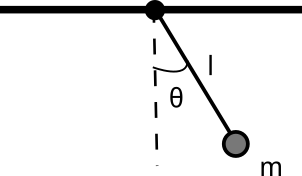

In [14]:
# Our system (pendulum)
def pendulum_dynamics(x, u):
    g = 9.81
    l = 1.
    m = 1.
    x_dot = np.concatenate([x[1:], -(g/l)*np.sin(x[:1]) + 1./(m*l*l)*u], axis=0)
    return x_dot

def pendulum_rk4(x, u, dt = 0.05):
    f1 = pendulum_dynamics(x, u)
    f2 = pendulum_dynamics(x + 0.5 * dt * f1, u)
    f3 = pendulum_dynamics(x + 0.5 * dt * f2, u)
    f4 = pendulum_dynamics(x + dt * f3, u)
    x_n = x + (dt/6.)*(f1 + 2. * f2 + 2. * f3 + f4)
    return x_n

In [15]:
# A few helpers
def angle_dist(b, a):
    theta = b - a
    while theta < -np.pi:
        theta += 2. * np.pi
    while theta > np.pi:
        theta -= 2. * np.pi
    return theta

In [16]:
# We first need to create our policy. We want neural network with one hidden layer with nH neurons. The activation function should be `tanh()` 
# both in the hidden and the output layer.
class policy_net(nn.Module):
    # define policy network
    def __init__(self, nS, nH, nA):  # nS: state space size, nH: n. of neurons in hidden layer, nA: action space size
        super().__init__()
        self.calls = 0
        ### TO-DO: Implement structure
        ### ANSWER: Insert code here
        self.nS = nS
        self.nH = nH
        self.nA = nA
        # Define the neural network layers
        # The first layer is a linear layer with nS inputs and nH outputs, followed by a tanh activation function.
        self.linear1 = nn.Linear(self.nS, self.nH)
        self.linear2 = nn.Linear(self.nH, self.nA)

        ### END of ANSWER

    # define forward pass
    def forward(self, x):
        self.calls += 1
        ### TO-DO: Forward pass
        ### ANSWER: Insert code here
        # Apply the first linear layer and tanh activation function
        x = torch.tanh(self.linear1(x))
        # Apply the second linear layer to get the action
        x = self.linear2(x) 
        # Apply tanh activation function to the output layer
        x = torch.tanh(x)
        # Return the action
        return x
        ### END of ANSWER

# We then need to create our critic! We want neural network with one hidden layer with nH neurons.
class critic_net(nn.Module):
    # define policy network
    def __init__(self, nS, nH, nA):  # nS: state space size, nH: n. of neurons in hidden layer, nA: action space size
        super().__init__()
        self.calls = 0
        ### TO-DO: Implement structure
        ### ANSWER: Insert code here one hidden layer with nH neurons.
        self.nS = nS
        self.nH = nH
        self.nA = nA
        # Define the neural network layers
        # The first layer is a linear layer with nS inputs and nH outputs, followed by a tanh activation function.
        self.linear1 = nn.Linear(self.nS+self.nA, self.nH)
        self.linear2 = nn.Linear(self.nH, 1)
        # The second layer is a linear layer with nH inputs and 1 output.

        ### END of ANSWER

    # define forward pass
    def forward(self, x, a):
        self.calls += 1
        ### TO-DO: Forward pass
        ### ANSWER: Insert code here
        # Concatenate state and action
        x = torch.cat([x, a], dim=-1)
        # Apply the first linear layer and tanh activation function
        x = torch.tanh(self.linear1(x))
        # Apply the second linear layer to get the action
        x = self.linear2(x)
        # Apply tanh activation function to the output layer
        #x = torch.tanh(x)
        # Return the action
        return x
        ### END of ANSWER

In [17]:
torch.manual_seed(1) # for testing
N = 10
H = 100
A = 5

model = policy_net(N, H, A)

params = list(model.named_parameters())
assert(params[0][1].size() == torch.Size([H, N]))
assert(params[2][1].size() == torch.Size([A, H]))

B = 25

x = torch.randn(B, N)
assert(torch.isclose(model(x).sum(), torch.Tensor([-11.637]), rtol=1e-3))

x = torch.randn(B, N)
assert(torch.isclose(model(x).sum(), torch.Tensor([-7.1595]), rtol=1e-3))


In [18]:
torch.manual_seed(1) # for testing
N = 10
H = 100
A = 5

model = critic_net(N, H, A)

params = list(model.named_parameters())
assert(params[0][1].size() == torch.Size([H, N+A]))
assert(params[2][1].size() == torch.Size([1, H]))

B = 25

x = torch.randn(B, N)
a = torch.randn(B, A)
assert(torch.isclose(model(x, a).sum(), torch.Tensor([-0.4080]), rtol=1e-3))

x = torch.randn(B, N)
a = torch.randn(B, A)
assert(torch.isclose(model(x, a).sum(), torch.Tensor([-0.1499]), rtol=1e-3))


In [19]:
# Let's create the policy: input= dims of state space (3), hidden units (XX), dims of action space (1)
policy = policy_net(3, 10, 1)
# Let's create our critic: similar inputs as above
critic = critic_net(3, 10, 1)
# create an optimizer
learning_rate = 1e-4 ### TO-DO: You might need to play with the learning rate!
optimizer = torch.optim.Adam(policy.parameters(), lr=learning_rate)
critic_learning_rate = 5e-3 ### TO-DO: You might need to play with the learning rate!
critic_optimizer = torch.optim.Adam(critic.parameters(), lr=critic_learning_rate)
# initialize gamma and stats
gamma = 1.
n_episode = 1
returns = deque(maxlen=200)

In [20]:
# Now let's create a function that calls the policy and returns an action. We would like to also add some Gaussian noise to the action.
def sample_action(policy, x_input, noise_range):
    # policy is our neural network
    # x_input is a 3x1 torch tensor
    # noise_range is a positive scalar that defines the noise range we would like to add
    ### TO-DO: Query the policy and add noise. Use a Gaussian with zero mean and variance one (torch.randn_like() is handy!), clamp the noise in [-noise_range, noise_range]
    ### TO-DO: Remember that the policy outputs actions in [-1., 1.]. Store the action in a variable named `action`
    ### ANSWER: Insert code here
    # https://pytorch.org/docs/stable/generated/torch.randn_like.html
    action = policy(x_input)
    
    g_noise = torch.randn_like(action)
    '''
    Returns a tensor with the same size as input that is filled with random
    numbers from a normal distribution with mean 0 and variance 1.
    '''
    g_noise = torch.clamp(g_noise, -noise_range, noise_range) # Clamp => [-noise_range, noise_range]

    action = action + g_noise
    action = torch.clamp(action, -1., 1.) # Remember that the policy outputs actions in [-1., 1.]!
    ### END of ANSWER
    return action

def sample_action1(policy, x_input, noise_range):
    # policy is our neural network
    # x_input is a 3x1 torch tensor
    # noise_range is a positive scalar that defines the noise range we would like to add
    ### TO-DO: Query the policy and add noise. Use a Gaussian with zero mean and variance one (torch.randn_like() is handy!), clamp the noise in [-noise_range, noise_range]
    ### TO-DO: Remember that the policy outputs actions in [-1., 1.]. Store the action in a variable named `action`
    ### ANSWER: Insert code here
    
    action = policy(x_input)
    noise= torch.randn_like(action)
    noise = torch.clamp(noise, -noise_range, noise_range)
    
    
    action = action + noise
    action = torch.clamp(action, -1., 1.)
    ### END of ANSWER
    return action
    '''action = policy(x_input)
    
    g_noise = torch.randn_like(action)
    
    Returns a tensor with the same size as input that is filled with random
    numbers from a normal distribution with mean 0 and variance 1.
    
    g_noise = torch.clamp(g_noise, -noise_range, noise_range) # Clamp => [-noise_range, noise_range]

    action = action + g_noise
    action = torch.clamp(action, -1., 1.) # Remember that the policy outputs actions in [-1., 1.]!
    ### END of ANSWER
    return action'''

def compute_q_target(policy, critic, x_next, rewards, not_dones, noise_range):
    # policy is our neural network for the policy/actor
    # critic is our neural network for the critic
    # x_next is a Bx3 torch tensor representing the visited next states (s', B is the batch size)
    # rewards is a Bx1 torch tensor with the rewards collected
    # not_dones is a Bx1 torch tensor with the ~dones collected
    # noise_range is a positive scalar that defines the noise range we use for sampling actions
    with torch.no_grad():
        ### TO-DO: Compute Q target. Store the result in a variable named `q_target`
        ### ANSWER: Insert code here
        next_actions = sample_action(policy, x_next, noise_range)
        #print(f"{x_next.shape}, {next_actions.shape}")
        next_q_values = critic(x_next, next_actions) # Υπολόγισε Q(s', a')

        q_target = rewards + gamma * next_q_values * not_dones
        ### END of ANSWER
    return q_target

def compute_q_loss(q_target, critic, x_curr, actions):
    # critic is our neural network for the critic
    # x_curr is a Bx3 torch tensor representing the visited states (B is the batch size)
    # actions is a Bx1 torch tensor with the actions taken in the environment

    ### TO-DO: Compute the Q loss. Store it in a variable named `q_loss`. Use the `mean` reduction.
    ### ANSWER: Insert code here
    # Compute the Q values for the current states and actions
    q_values = critic(x_curr, actions) # Υπολόγισε Q(s, a)
    # Compute the mean squared error between the Q target and the Q values
    q_loss = F.mse_loss(q_values, q_target, reduction='mean') # Υπολόγισε L(θ) = (Q(s, a) - Q_target)^2
    # Compute the mean squared error between the Q target and the Q values
    ### END of ANSWER
    return q_loss

def update_critic(policy, critic, critic_optimizer, x_curr, x_next, actions, rewards, not_dones, noise_range):
    # policy is our neural network for the policy/actor
    # critic is our neural network for the critic
    # critic_optimizer is the optimizer for the critic
    # x_curr is a Bx3 torch tensor representing the visited states (B is the batch size)
    # x_next is a Bx3 torch tensor representing the visited next states (s')
    # actions is a Bx1 torch tensor with the actions taken in the environment
    # rewards is a Bx1 torch tensor with the rewards collected
    # not_dones is a Bx1 torch tensor with the ~dones collected
    # noise_range is a positive scalar that defines the noise range we use for sampling actions

    ### Update of the Q function for DPG
    q_target = compute_q_target(policy, critic, x_next, rewards, not_dones, noise_range)
    q_loss = compute_q_loss(q_target, critic, x_curr, actions)

    critic_optimizer.zero_grad()
    q_loss.backward()
    critic_optimizer.step()

def compute_actor_loss(policy, critic, x_curr):
    # policy is our neural network for the policy/actor
    # critic is our neural network for the critic
    # x_curr is a Bx3 torch tensor representing the visited states (B is the batch size)
    ### TO-DO: Compute the actor loss of DPG. Do not inject noise. Save the result in a variable named `actor_loss`. Use the `mean` reduction.
    ### ANSWER: Insert code here
    # Compute the actions for the current states
    actions = policy(x_curr) # Υπολόγισε a(s)
    # Compute the Q values for the current states and actions
    q_values = critic(x_curr, actions) # Υπολόγισε Q(s, a)
    # Compute the actor loss as the negative mean of the Q values
    # The actor loss is the negative of the Q values, as we want to maximize the Q values
    # The mean is taken over the batch size
    actor_loss = -torch.mean(q_values) # Υπολόγισε L(θ) = -Q(s, a)
    
    ### END of ANSWER
    return actor_loss

def update_actor(policy, critic, policy_optimizer, x_curr):
    # policy is our neural network for the policy/actor
    # critic is our neural network for the critic
    # policy_optimizer is the optimizer for the policy
    # x_curr is a Bx3 torch tensor representing the visited states (B is the batch size)

    # Get the actor loss
    actor_loss = compute_actor_loss(policy, critic, x_curr)

    policy_optimizer.zero_grad()
    actor_loss.backward()
    policy_optimizer.step()

In [21]:
B = 10
N = 3

x = torch.randn(B, N)

assert(torch.isclose(policy(x), sample_action(policy, x, 0.)).all())
assert(not torch.isclose(policy(x), sample_action(policy, x, 0.2)).all())


In [22]:
B = 10

x = torch.ones(B, 3)
a = torch.ones(B, 1)
xn = torch.ones(B, 3) * 2.
rewards = torch.randn(B, 1)
not_dones = torch.zeros(B, 1)

critic_optimizer.zero_grad()
optimizer.zero_grad()

q_target = compute_q_target(policy, critic, xn, rewards, not_dones, 0.)
assert(torch.isclose(q_target, rewards).all())

q_loss = compute_q_loss(q_target, critic, x, a)
assert((q_loss >= 0.).all())


for name, param in policy.named_parameters():
    if param.requires_grad and param.grad is not None:
        assert(torch.isclose(torch.square(param.grad).sum(), torch.Tensor([0.])).all())

for name, param in critic.named_parameters():
    if param.requires_grad and param.grad is not None:
        assert(torch.isclose(torch.square(param.grad).sum(), torch.Tensor([0.])).all())

In [23]:
B = 10

x = torch.ones(B, 3)

critic_optimizer.zero_grad()
optimizer.zero_grad()

pc = policy.calls
cc = critic.calls
compute_actor_loss(policy, critic, x)
assert((pc + 1) == policy.calls)
assert((cc + 1) == critic.calls)


for name, param in policy.named_parameters():
    if param.requires_grad and param.grad is not None:
        assert(torch.isclose(torch.square(param.grad).sum(), torch.Tensor([0.])).all())

for name, param in critic.named_parameters():
    if param.requires_grad and param.grad is not None:
        assert(torch.isclose(torch.square(param.grad).sum(), torch.Tensor([0.])).all())

In [24]:
x_pendulum = np.array([[np.pi, 0.]]).T
x_init = np.copy(x_pendulum)

# Max torque/velocity
max_torque = 2.
max_vel = 2.
noise_range = 0.1

all_returns = []
smoothed_returns = []
smoothed_return = None
max_steps = 8000 * 82
total_steps = 0
while total_steps < max_steps:
    rewards = []
    actions = []
    states = []
    not_dones = []
    # reset environment
    x_pendulum = np.copy(x_init)

    n_steps = 0
    while True:
        # Query policy and get action with noise!
        x_input = np.array([[np.cos(x_pendulum[0, 0]), np.sin(x_pendulum[0, 0]), x_pendulum[1, 0]]]).T
        action = sample_action(policy, torch.tensor(x_input.T).float(), noise_range)
        # Transform action from [-1., 1] to actual [-τ, τ]
        u = action.item() * max_torque

        # step the environment
        x_new = pendulum_rk4(x_pendulum, u)
        x_new[1, 0] = max(-max_vel, min(max_vel, x_new[1, 0]))
        reward = 1.
        done = abs(angle_dist(np.pi, x_new[0, 0])) > 0.349066

        # store state, action and reward
        states.append(x_input.T)
        actions.append(action.item())
        rewards.append(reward)

        if done:
            not_dones.append(0.)
        else:
            not_dones.append(1.)

        x_pendulum = np.copy(x_new)

        total_steps += 1
        if n_steps > 80 or done:
            x_input = np.array([[np.cos(x_pendulum[0, 0]), np.sin(x_pendulum[0, 0]), x_pendulum[1, 0]]]).T
            states.append(x_input.T)
            break
        n_steps += 1

    # preprocess rewards
    rewards = np.array(rewards)
    all_returns += [np.sum(rewards)]
    alpha = 0.6
    if smoothed_return is None:
        smoothed_return = all_returns[-1]
    smoothed_return = alpha * smoothed_return + (1. - alpha) * all_returns[-1]
    smoothed_returns += [smoothed_return]

    # Batch Update!
    actions = torch.tensor(actions).float().reshape((-1, 1))
    not_dones = torch.tensor(not_dones).float().reshape((-1, 1))
    torch_rewards = torch.tensor(rewards).float().reshape((-1, 1))
    x_curr = torch.tensor(np.array(states[:-1])).float().reshape((-1, 3))
    x_next = torch.tensor(np.array(states[1:])).float().reshape((-1, 3))

    # Update critic
    update_critic(policy, critic, critic_optimizer, x_curr, x_next, actions, torch_rewards, not_dones, noise_range)

    # Update actor
    update_actor(policy, critic, optimizer, x_curr)

    # calculate average return and print it out
    returns.append(np.sum(rewards))
    if n_episode % 200 == 0 or n_episode == 1:
        print("Steps: {:6d}\tAvg. Return: {:6.2f}\tNoise: {:6.2f}".format(total_steps, np.mean(returns), noise_range))
    n_episode += 1

    # Reduce noise as episodes progress
    noise_range = max(noise_range * 0.9999, 0.01)

Steps:     18	Avg. Return:  18.00	Noise:   0.10
Steps:   3367	Avg. Return:  16.84	Noise:   0.10
Steps:   6332	Avg. Return:  14.82	Noise:   0.10
Steps:   9260	Avg. Return:  14.64	Noise:   0.09
Steps:  12501	Avg. Return:  16.20	Noise:   0.09
Steps:  16798	Avg. Return:  21.48	Noise:   0.09
Steps:  24025	Avg. Return:  36.13	Noise:   0.09
Steps:  30979	Avg. Return:  34.77	Noise:   0.09
Steps:  37949	Avg. Return:  34.85	Noise:   0.09
Steps:  45383	Avg. Return:  37.17	Noise:   0.08
Steps:  52708	Avg. Return:  36.62	Noise:   0.08
Steps:  60396	Avg. Return:  38.44	Noise:   0.08
Steps:  68315	Avg. Return:  39.59	Noise:   0.08
Steps:  76167	Avg. Return:  39.26	Noise:   0.08
Steps:  84568	Avg. Return:  42.01	Noise:   0.08
Steps:  93082	Avg. Return:  42.57	Noise:   0.07
Steps: 101367	Avg. Return:  41.42	Noise:   0.07
Steps: 110154	Avg. Return:  43.94	Noise:   0.07
Steps: 118826	Avg. Return:  43.36	Noise:   0.07
Steps: 128175	Avg. Return:  46.74	Noise:   0.07
Steps: 137492	Avg. Return:  46.59	Noise:

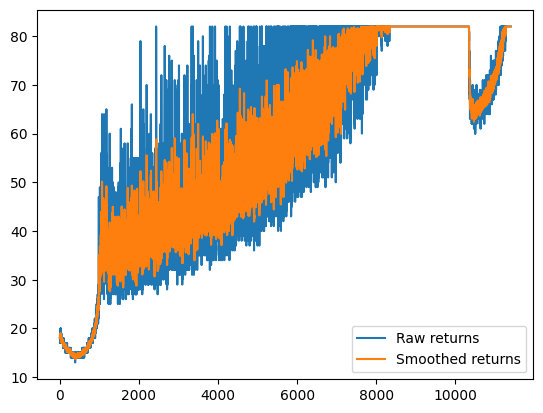

In [25]:
# Plot learning
fig, ax = plt.subplots(1, 1)

xx = np.arange(len(all_returns))

ax.plot(xx, all_returns, label="Raw returns")
ax.plot(xx, smoothed_returns, label="Smoothed returns")

ax.legend()

plt.show()